In [12]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import random
import xarray as xr
#from keras import optimizers
from sklearn import preprocessing
from keras.callbacks import History
import matplotlib.pyplot as plt
from plain_neural_network import*

In [13]:
input_input_paths = "/work/ollie/bpanthi/nn_interpolation/ssh_gridded_1961_001_1_m.nc"
target_img_paths = "/home/ollie/ssunar/segmentation_masks/segmentation_mask_nn_1961_001_1_m.nc"
file_path_save = "/work/ollie/bpanthi/NN_weights"
data_x = xr.open_dataset(input_input_paths)
data_y = xr.open_dataset(target_img_paths)
data_x = data_x.ssh.to_numpy()
data_y = data_y.seg_mask.to_numpy()
data_x = np.float32(data_x)
data_y = np.float32(data_y)
img_size = (1200, 480)
num_classes = 3
batch_size = 5
epochs = 50
total_samples = len(data_x)

In [14]:
print(data_x[0])
print(np.max(data_x))
print(np.min(data_x))

[[-7.0383692e-01 -6.9714171e-01 -6.9363987e-01 ...  9.9692100e+36
   9.9692100e+36  9.9692100e+36]
 [-7.4457765e-01 -7.2361225e-01 -7.2052300e-01 ...  9.9692100e+36
   9.9692100e+36  9.9692100e+36]
 [-7.6013374e-01 -7.4673313e-01 -7.4736404e-01 ...  9.9692100e+36
   9.9692100e+36  9.9692100e+36]
 ...
 [-1.6232173e+00 -1.6178026e+00 -1.6113625e+00 ...  9.9692100e+36
   9.9692100e+36  9.9692100e+36]
 [-1.6377305e+00 -1.6311280e+00 -1.6258327e+00 ...  9.9692100e+36
   9.9692100e+36  9.9692100e+36]
 [-1.6477681e+00 -1.6418573e+00 -1.6364002e+00 ...  9.9692100e+36
   9.9692100e+36  9.9692100e+36]]
9.96921e+36
-1.9317486


In [15]:
#Work on this part
# for i in range(total_samples):
#     data_x[i] = (2*float(data_x[i] - np.min(data_x[i])))/(np.max(data_x[i]) - np.min(data_x[i])) - 1 
# for i in range(total_samples):
#     scaler = preprocessing.StandardScaler().fit(data_x[i])
#     data_x[i] = scaler.transform(data_x[i])
data_x[data_x>1000] = 0
print(data_x[0])
print(np.max(data_x))
print(np.min(data_x))
print(np.size(data_y[0][data_y[0]==0]))
print(np.size(data_y[0][data_y[0]==1]))
print(np.size(data_y[0][data_y[0]==2]))

[[-0.7038369  -0.6971417  -0.6936399  ...  0.          0.
   0.        ]
 [-0.74457765 -0.72361225 -0.720523   ...  0.          0.
   0.        ]
 [-0.76013374 -0.7467331  -0.74736404 ...  0.          0.
   0.        ]
 ...
 [-1.6232173  -1.6178026  -1.6113625  ...  0.          0.
   0.        ]
 [-1.6377305  -1.631128   -1.6258327  ...  0.          0.
   0.        ]
 [-1.6477681  -1.6418573  -1.6364002  ...  0.          0.
   0.        ]]
1.0931604
-1.9317486
516648
28040
31312


In [16]:
# Split our img paths into a training and a validation set
split = 0.2
train_samples = int((1-split)*total_samples)
#same seed must be used
random.Random(0).shuffle(data_x)
random.Random(0).shuffle(data_y)
train_input = data_x[0:train_samples]
train_target = data_y[0:train_samples]
val_input = data_x[train_samples:total_samples]
val_target = data_y[train_samples:total_samples]

print("train_input:", train_input.shape)
print("val_input:", val_input.shape)
#print(train_target[0][200])

# Instantiate data Sequences for each split
train_gen = plain_net_eddy(batch_size, img_size, train_input, train_target)
val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)

train_input: (23, 1200, 480)
val_input: (6, 1200, 480)


In [17]:
model = get_model(img_size, num_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1200, 480, 1)]    0         
                                                                 
 separable_conv2d_6 (Separab  (None, 1200, 480, 16)    41        
 leConv2D)                                                       
                                                                 
 batch_normalization_13 (Bat  (None, 1200, 480, 16)    64        
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 1200, 480, 16)     0         
                                                                 
 separable_conv2d_7 (Separab  (None, 1200, 480, 16)    416       
 leConv2D)                                                       
                                                           

 batch_normalization_25 (Bat  (None, 1200, 480, 8)     32        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 1200, 480, 3)      219       
                                                                 
Total params: 18,220
Trainable params: 17,820
Non-trainable params: 400
_________________________________________________________________


In [18]:
#Work on this part
from keras import backend as K
smooth = 1.  # to avoid zero division

def dice_coef_anti(y_true, y_pred):
    y_true_anti = (y_true[:,:,1])
    y_pred_anti = (y_pred[:,:,1])
    intersection_anti = K.sum(y_true_anti) * (y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = (y_true[:,:,2])
    y_pred_cyc = (y_pred[:,:,2])
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    y_true_nn = (y_true[:,:,0])
    y_pred_nn = (y_pred[:,:,0])
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    return (0.36*dice_coef_anti(y_true, y_pred) + 0.62*dice_coef_cyc(y_true, y_pred) + 0.02*dice_coef_nn(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

In [19]:
#optimizer = keras.optimizers.Adam(clipvalue=0.5)
#model.compile(optimizer="adam", loss=dice_coef_loss)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
#model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint(file_path_save, save_best_only=True , monitor='val_loss')]

# Train the model, doing validation at the end of each epoch.
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
4/4 [==============================] - 15s 4s/step - loss: 1.2487 - val_loss: 1.0902
Epoch 2/50
4/4 [==============================] - 13s 4s/step - loss: 1.1337 - val_loss: 1.0810
Epoch 3/50
4/4 [==============================] - 13s 4s/step - loss: 1.0964 - val_loss: 1.0717
Epoch 4/50
4/4 [==============================] - 13s 4s/step - loss: 1.0743 - val_loss: 1.0621
Epoch 5/50
4/4 [==============================] - 13s 4s/step - loss: 1.0573 - val_loss: 1.0498
Epoch 6/50
4/4 [==============================] - 13s 4s/step - loss: 1.0417 - val_loss: 1.0333
Epoch 7/50
4/4 [==============================] - 13s 4s/step - loss: 1.0262 - val_loss: 1.0142
Epoch 8/50
4/4 [==============================] - 13s 4s/step - loss: 1.0096 - val_loss: 0.9915
Epoch 9/50
4/4 [==============================] - 13s 4s/step - loss: 0.9906 - val_loss: 0.9645
Epoch 10/50
4/4 [==============================] - 13s 4s/step - loss: 0.9696 - val_loss: 0.9356
Epoch 11/50
4/4 [======================

Epoch 43/50
4/4 [==============================] - 8s 2s/step - loss: 0.3360 - val_loss: 0.4858
Epoch 44/50
4/4 [==============================] - 8s 2s/step - loss: 0.3320 - val_loss: 0.4935
Epoch 45/50
4/4 [==============================] - 8s 2s/step - loss: 0.3300 - val_loss: 0.5099
Epoch 46/50
4/4 [==============================] - 8s 2s/step - loss: 0.3275 - val_loss: 0.5131
Epoch 47/50
4/4 [==============================] - 8s 2s/step - loss: 0.3259 - val_loss: 0.5174
Epoch 48/50
4/4 [==============================] - 8s 2s/step - loss: 0.3218 - val_loss: 0.5276
Epoch 49/50
4/4 [==============================] - 8s 2s/step - loss: 0.3190 - val_loss: 0.5289
Epoch 50/50
4/4 [==============================] - 8s 2s/step - loss: 0.3147 - val_loss: 0.5326


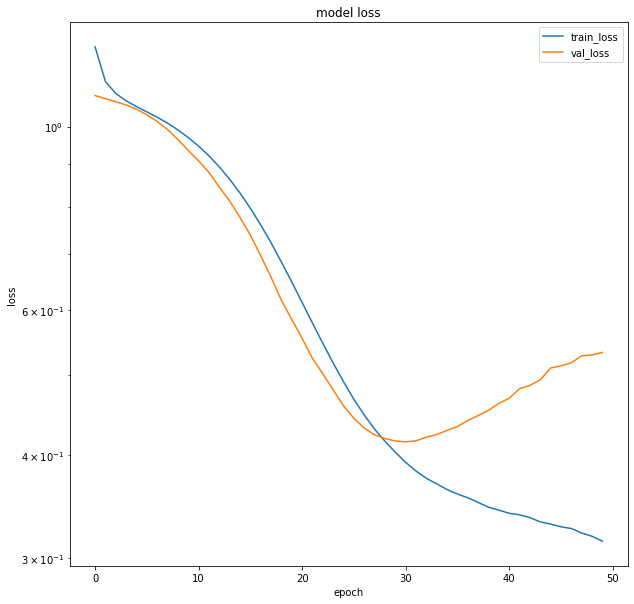

In [20]:
plt.figure(figsize=(10, 10))
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');

In [21]:
val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
val_preds = model.predict(val_gen)
print(val_preds.shape)
print(val_preds[0][0][0])
print(val_preds[0][10][10])
print(val_preds[0][100][100])

(5, 1200, 480, 3)
[0.72567457 0.14212108 0.13220441]
[0.97754955 0.01185351 0.01059693]
[0.98435867 0.0079189  0.00772244]
